In [1]:
# Importamos librerias necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import category_encoders as ce

In [2]:
# Importamos el set de testeo provisto
inmuebles = pd.read_parquet("train.parquet")

In [3]:
# Revisamos las primeras lineas del dataset
inmuebles.head()


,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
0,7048013474,https://boise.craigslist.org/apa/d/very-nice-b...,boise,https://boise.craigslist.org,1350,house,1200,2,2.0,1,...,0,0,0,w/d in unit,detached garage,https://images.craigslist.org/00B0B_cPiJMEheZe...,Super cute row house in the Boise bench area. ...,43.5851,-116.2250,id
1,7043931179,https://cosprings.craigslist.org/apa/d/colorad...,colorado springs,https://cosprings.craigslist.org,1115,apartment,694,1,1.0,1,...,0,0,0,w/d in unit,carport,https://images.craigslist.org/00R0R_5XAoSKvfrz...,Windtree Apartment Homes currently has a spaci...,38.9137,-104.7800,co
2,7048254516,https://norfolk.craigslist.org/apa/d/virginia-...,norfolk / hampton roads,https://norfolk.craigslist.org,1129,apartment,900,2,2.0,0,...,0,0,0,w/d hookups,off-street parking,https://images.craigslist.org/00f0f_3ZbTFrsHpZ...,Call Today! show contact info Indian Lakes ...,36.7922,-76.1643,va
3,7041032577,https://phoenix.craigslist.org/nph/apa/d/phoen...,phoenix,https://phoenix.craigslist.org,1580,house,1469,3,2.0,1,...,0,0,0,w/d in unit,None,https://images.craigslist.org/00f0f_aXV5Dkd5qk...,Cody Anderson Two Brothers Realty License #: S...,33.5623,-112.0560,az
4,7048588701,https://nashville.craigslist.org/apa/d/antioch...,nashville,https://nashville.craigslist.org,995,apartment,700,1,1.0,1,...,0,0,0,w/d in unit,carport,https://images.craigslist.org/00606_gYOGKClOHv...,To schedule a tour We now book our tour appoin...,36.0595,-86.6592,tn


In [4]:
# Revisamos existencia de valores nulos
inmuebles.isnull().sum()

id                              0
url                             0
region                          0
region_url                      0
price                           0
type                            0
sqfeet                          0
beds                            0
baths                           0
cats_allowed                    0
dogs_allowed                    0
smoking_allowed                 0
wheelchair_access               0
electric_vehicle_charge         0
comes_furnished                 0
laundry_options             71171
parking_options            126682
image_url                       0
description                     2
lat                          1722
long                         1722
state                           0
dtype: int64

In [5]:
# Vamos a crear la nueva columna con las dos categorias de precios (1 = low, 0 = medium & high)
conditions = [
    (inmuebles['price'] >= 0) & (inmuebles['price'] <= 999),
    (inmuebles['price'] >= 1000)]
choices = ['1', '0']
inmuebles['category_price'] = np.select(conditions, choices).astype(int)

In [11]:
inmuebles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346479 entries, 0 to 346478
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       346479 non-null  int64  
 1   url                      346479 non-null  object 
 2   region                   346479 non-null  object 
 3   region_url               346479 non-null  object 
 4   price                    346479 non-null  int64  
 5   type                     346479 non-null  object 
 6   sqfeet                   346479 non-null  int64  
 7   beds                     346479 non-null  int64  
 8   baths                    346479 non-null  float64
 9   cats_allowed             346479 non-null  int64  
 10  dogs_allowed             346479 non-null  int64  
 11  smoking_allowed          346479 non-null  int64  
 12  wheelchair_access        346479 non-null  int64  
 13  electric_vehicle_charge  346479 non-null  int64  
 14  come

In [6]:
# Verificamos valores de la nueva columna y existencia de nulos
inmuebles.category_price.unique()

array([0, 1])

In [7]:
inmuebles.isnull().sum()

id                              0
url                             0
region                          0
region_url                      0
price                           0
type                            0
sqfeet                          0
beds                            0
baths                           0
cats_allowed                    0
dogs_allowed                    0
smoking_allowed                 0
wheelchair_access               0
electric_vehicle_charge         0
comes_furnished                 0
laundry_options             71171
parking_options            126682
image_url                       0
description                     2
lat                          1722
long                         1722
state                           0
category_price                  0
dtype: int64

<AxesSubplot: xlabel='category_price', ylabel='count'>

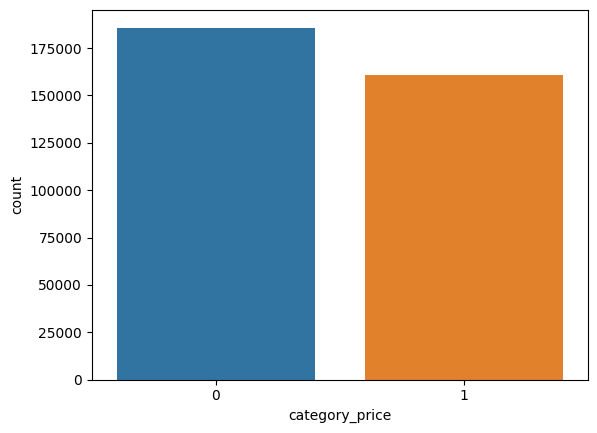

In [8]:
# Graficamos la distribución de la nueva columna
sns.countplot(x='category_price', data=inmuebles)

Vemos que las clases se encuentran balanceadas

In [9]:
# Verificamos existenvia de filas duplicadas
len(inmuebles)-len(inmuebles.drop_duplicates())

0

In [10]:
inmuebles.shape

(346479, 23)

Explorando el dataset, encontramos Descripciones repetidas, generalmente con mismo precio de alquiler y mismo URL de la imagen de la propiedad, por lo que decidimos eliminar estos registros repetidos dejando solamente uno, utilizando para ello la columna de la URL de la imagen ya que es la que mayor confianza nos otorga en cuanto a que se trata de la misma propiedad en alquiler.

Consideramos que el dato de cuantas veces se publicó la misma propiedad puede ser un indicativo del valor de su alquiler. Por lo tanto, vamos a incorporar una columna con la cantidad de veces que se publicó el aviso.

In [12]:
# Contamos la cantidad de valores repetidos en la columna "image_url"
len(inmuebles['image_url'])-len(inmuebles['image_url'].drop_duplicates())

178233

Vemos que un número importante, practicamente la mitad del dataset contiene republicaciones de la misma propieadad en alquiler

In [13]:
# Buscamos algun ejemplo para visualizar
df = inmuebles.loc[inmuebles['image_url'].duplicated(keep=False),'image_url']
df
df = df.groupby(df).apply(lambda x: tuple(x.index)).tolist()
df[24]

(66499, 70514, 173295, 215379, 309342, 331892)

In [14]:
inmuebles.loc[[66499,70514, 173295,215379,309342,331892],['price','image_url','description']]

,price,image_url,description
66499,1164,https://images.craigslist.org/00000_204WDl9WiP...,Welcome to Riverview Apartments. Please call f...
70514,1284,https://images.craigslist.org/00000_204WDl9WiP...,Welcome to Riverview Apartments. Please call f...
173295,1284,https://images.craigslist.org/00000_204WDl9WiP...,Welcome to Riverview Apartments. Please call f...
215379,1284,https://images.craigslist.org/00000_204WDl9WiP...,Welcome to Riverview Apartments. Please call f...
309342,1284,https://images.craigslist.org/00000_204WDl9WiP...,Welcome to Riverview Apartments. Please call f...
331892,1284,https://images.craigslist.org/00000_204WDl9WiP...,Welcome to Riverview Apartments. Please call f...


Conciden los datos, con una pequeña variación en el costo del alquiler que puede deberse al paso del tiempo y la inflaciòn de Estados Unidos

In [15]:
# Incorporamos una columna "publicaciones" que contiene la cantidad de veces que aparece el mismo anuncio en el dataset
inmuebles['publicaciones'] = inmuebles.groupby(['image_url'])['image_url'].transform('count')
inmuebles

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state,category_price,publicaciones
0,7048013474,https://boise.craigslist.org/apa/d/very-nice-b...,boise,https://boise.craigslist.org,1350,house,1200,2,2.0,1,...,0,w/d in unit,detached garage,https://images.craigslist.org/00B0B_cPiJMEheZe...,Super cute row house in the Boise bench area. ...,43.5851,-116.2250,id,0,1
1,7043931179,https://cosprings.craigslist.org/apa/d/colorad...,colorado springs,https://cosprings.craigslist.org,1115,apartment,694,1,1.0,1,...,0,w/d in unit,carport,https://images.craigslist.org/00R0R_5XAoSKvfrz...,Windtree Apartment Homes currently has a spaci...,38.9137,-104.7800,co,0,2
2,7048254516,https://norfolk.craigslist.org/apa/d/virginia-...,norfolk / hampton roads,https://norfolk.craigslist.org,1129,apartment,900,2,2.0,0,...,0,w/d hookups,off-street parking,https://images.craigslist.org/00f0f_3ZbTFrsHpZ...,Call Today! show contact info Indian Lakes ...,36.7922,-76.1643,va,0,1
3,7041032577,https://phoenix.craigslist.org/nph/apa/d/phoen...,phoenix,https://phoenix.craigslist.org,1580,house,1469,3,2.0,1,...,0,w/d in unit,None,https://images.craigslist.org/00f0f_aXV5Dkd5qk...,Cody Anderson Two Brothers Realty License #: S...,33.5623,-112.0560,az,0,1
4,7048588701,https://nashville.craigslist.org/apa/d/antioch...,nashville,https://nashville.craigslist.org,995,apartment,700,1,1.0,1,...,0,w/d in unit,carport,https://images.craigslist.org/00606_gYOGKClOHv...,To schedule a tour We now book our tour appoin...,36.0595,-86.6592,tn,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346474,7050982281,https://evansville.craigslist.org/apa/d/evansv...,evansville,https://evansville.craigslist.org,672,apartment,660,1,1.0,1,...,0,laundry on site,None,https://images.craigslist.org/00x0x_9oaHKZ8Ilp...,"The pool, the office, the 24-hour on-site laun...",37.9591,-87.5293,in,1,2
346475,7049418251,https://sandiego.craigslist.org/ssd/apa/d/chul...,san diego,https://sandiego.craigslist.org,2122,apartment,1099,2,2.0,1,...,0,w/d in unit,off-street parking,https://images.craigslist.org/00O0O_6QsU4p5WMh...,Seize your chance to live in our beautiful apa...,32.6279,-117.0370,ca,0,1
346476,7048268235,https://columbia.craigslist.org/apa/d/columbia...,columbia,https://columbia.craigslist.org,1014,apartment,1104,2,2.0,1,...,0,w/d hookups,off-street parking,https://images.craigslist.org/00000_dpNWqzYhGK...,Tucked into the rolling landscape of Southeast...,33.9659,-80.9355,sc,0,7
346477,7026721229,https://nd.craigslist.org/apa/d/minot-open-con...,north dakota,https://nd.craigslist.org,935,apartment,1050,2,2.0,0,...,0,w/d in unit,detached garage,https://images.craigslist.org/00Z0Z_65g6Cty1RX...,Enjoy living at Southwood Apartments! Located ...,48.1995,-101.2800,nd,1,21


In [16]:
# Ahora si eliminamos los anuncios duplicados
inmuebles.drop_duplicates(subset='image_url', inplace=True)

In [17]:
inmuebles.shape

(168246, 24)

Efectivamente, hemos reducido el dataset en un 51,4% del total de registros originales

In [18]:
inmuebles

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state,category_price,publicaciones
0,7048013474,https://boise.craigslist.org/apa/d/very-nice-b...,boise,https://boise.craigslist.org,1350,house,1200,2,2.0,1,...,0,w/d in unit,detached garage,https://images.craigslist.org/00B0B_cPiJMEheZe...,Super cute row house in the Boise bench area. ...,43.5851,-116.2250,id,0,1
1,7043931179,https://cosprings.craigslist.org/apa/d/colorad...,colorado springs,https://cosprings.craigslist.org,1115,apartment,694,1,1.0,1,...,0,w/d in unit,carport,https://images.craigslist.org/00R0R_5XAoSKvfrz...,Windtree Apartment Homes currently has a spaci...,38.9137,-104.7800,co,0,2
2,7048254516,https://norfolk.craigslist.org/apa/d/virginia-...,norfolk / hampton roads,https://norfolk.craigslist.org,1129,apartment,900,2,2.0,0,...,0,w/d hookups,off-street parking,https://images.craigslist.org/00f0f_3ZbTFrsHpZ...,Call Today! show contact info Indian Lakes ...,36.7922,-76.1643,va,0,1
3,7041032577,https://phoenix.craigslist.org/nph/apa/d/phoen...,phoenix,https://phoenix.craigslist.org,1580,house,1469,3,2.0,1,...,0,w/d in unit,None,https://images.craigslist.org/00f0f_aXV5Dkd5qk...,Cody Anderson Two Brothers Realty License #: S...,33.5623,-112.0560,az,0,1
4,7048588701,https://nashville.craigslist.org/apa/d/antioch...,nashville,https://nashville.craigslist.org,995,apartment,700,1,1.0,1,...,0,w/d in unit,carport,https://images.craigslist.org/00606_gYOGKClOHv...,To schedule a tour We now book our tour appoin...,36.0595,-86.6592,tn,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346460,7046734925,https://miami.craigslist.org/brw/apa/d/fort-la...,south florida,https://miami.craigslist.org,1565,apartment,720,1,1.0,0,...,0,None,None,https://images.craigslist.org/00q0q_eqjRAloITz...,Come Home to Bell at Plantation Apartments in ...,26.1467,-80.2433,fl,0,1
346462,7031598723,https://dayton.craigslist.org/apa/d/dayton-dec...,dayton / springfield,https://dayton.craigslist.org,479,apartment,562,1,1.0,1,...,0,laundry on site,off-street parking,https://images.craigslist.org/00s0s_8MWbqu0lvf...,Avalon Place Apartments & Townhomes 2196 Rockd...,39.7824,-84.0271,oh,1,1
346466,7045689575,https://boston.craigslist.org/gbs/apa/d/brookl...,boston,https://boston.craigslist.org,3155,apartment,896,1,1.0,0,...,0,w/d in unit,None,https://images.craigslist.org/00P0P_egXeeJ2jUR...,PROPERTY INFO ID: 184600979Rent: 3155 / MonthB...,42.3431,-71.1230,ma,0,1
346475,7049418251,https://sandiego.craigslist.org/ssd/apa/d/chul...,san diego,https://sandiego.craigslist.org,2122,apartment,1099,2,2.0,1,...,0,w/d in unit,off-street parking,https://images.craigslist.org/00O0O_6QsU4p5WMh...,Seize your chance to live in our beautiful apa...,32.6279,-117.0370,ca,0,1


<AxesSubplot: xlabel='category_price', ylabel='count'>

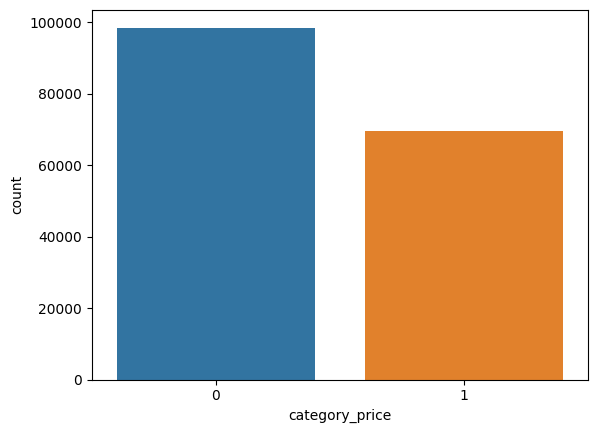

In [19]:
# Volvemos a revisar la distribución del target
sns.countplot(x='category_price', data=inmuebles)

Vamos a analizar ahora cada columna en particular, pero antes eliminaremos aquellas que no utilizaremos

In [20]:
correlaciones = inmuebles[["id","lat","long","category_price"]].copy()

In [21]:
correlaciones.corr()


,id,lat,long,category_price
id,1.000000,-0.021692,-0.092363,-0.128221
lat,-0.021692,1.000000,-0.109377,-0.020959
long,-0.092363,-0.109377,1.000000,0.170015
category_price,-0.128221,-0.020959,0.170015,1.000000


Vemos que la longitud amerita participar del modelo debido a su correlación con el precio. Entendemos que obedece a que indica cercania con el mar.
Eliminaremos las otras tres, ademas de "price" que es un dato que no estará presente en el set de testeo de Henry, y las que creemos que no aportan valor o representan una gran dificultad para incorporar al modelo como "url", "region", "region_url", "image_url" y "description"

In [23]:
inmuebles.drop(["id","lat","url", "region", "region_url", "image_url","description","price"],axis = 1, inplace = True)

Revisemos una matriz de correlación del estado actual del dataframe para eliminar algunas columnas adicionales que en principio no serían de utilidad

In [26]:
inmuebles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168246 entries, 0 to 346478
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   type                     168246 non-null  object 
 1   sqfeet                   168246 non-null  int64  
 2   beds                     168246 non-null  int64  
 3   baths                    168246 non-null  float64
 4   cats_allowed             168246 non-null  int64  
 5   dogs_allowed             168246 non-null  int64  
 6   smoking_allowed          168246 non-null  int64  
 7   wheelchair_access        168246 non-null  int64  
 8   electric_vehicle_charge  168246 non-null  int64  
 9   comes_furnished          168246 non-null  int64  
 10  laundry_options          134952 non-null  object 
 11  parking_options          112552 non-null  object 
 12  long                     167328 non-null  float64
 13  state                    168246 non-null  object 
 14  cate

In [ ]:
# Las columnas "id", "url", "region", "region_url", "price", "image_url, "description", "lat" y "long"
# no serán utilizadas en los modelos. "price" es un dato que no tendremos en el testeo de Henry    

In [ ]:
# Vemos la distribución de la columna "type"
sns.countplot(y='type', data=inmuebles)

In [ ]:
# Veamos la relación entre el precio del alquiler y el tipo de vivienda
agr = inmuebles.groupby(['type', 'category_price']).size().reset_index().pivot(columns='category_price', index='type', values=0)
agr.plot(kind='bar', stacked=True)

Notamos que en las casas, condominios y townhouses la proporcion de alquileres mayores a $999 es mayor, por lo que en principio dejariamos esta columna

In [ ]:
# Hacemos una descripción del Dataframe
inmuebles.describe()

Notamos la existencia de outliers en varias columnas, por ejemplo, un valor máximo de 1.100 camas o 75 baños. Analizaremos a continuación cada una de las columnas

In [ ]:
inmuebles.corr()

In [ ]:
inmuebles.sort_values("sqfeet",ascending=False)

In [ ]:
def outlier_treatment(datacolumn):
    """
    Función para detectar outliers
    """
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [5,97])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

In [ ]:
lowerbound,upperbound = outlier_treatment(inmuebles.sqfeet)

In [ ]:
print (lowerbound," ",upperbound)

In [ ]:
sorted(inmuebles.sqfeet)

In [ ]:
sns.boxplot(x="sqfeet", data=inmuebles[inmuebles["sqfeet"]>50])

In [ ]:
sns.boxplot(x = 'sqfeet', data = inmuebles, showfliers = False)

In [ ]:
sns.boxplot(x = 'sqfeet', data = inmuebles, flierprops = dict(markerfacecolor = '0.50', markersize = 2))

Como vemos en este artículo online (https://www.fool.com/the-ascent/research/average-house-price-state/#:~:text=The%20median%20home%20price%20in,in%20the%20U.S.%20at%20%24354%2C649.), el Estado en el cual se ubican las propiedades tiene gran influencia sobre el precio promedio de las mismas.
Por lo tanto, vamos a utilizar la columna "state", pero necesitamos transformarla en valores numéricos.
Haremos esto mediante el método de Binary Encoding, ya que el One-Hot Encoding nos crearía demasiadas nuevas columnas

In [ ]:
inmuebles_ce = inmuebles.copy()

encoder = ce.BinaryEncoder(cols=['state'])
inmuebles_binary = encoder.fit_transform(inmuebles_ce)

inmuebles_binary.head()

In [ ]:
# Pasamos a valores numericos la clase "category_price" para poder analizar correlaciones

inmuebles_binary['categoria']=inmuebles_binary["category_price"]
inmuebles_binary['categoria'].replace(['low', 'medium', 'high'],
                        [0, 1, 2], inplace=True)

In [ ]:
# Generamos un dataframe para hacer las primeras pruebas
inmuebles_v1 = inmuebles_binary

In [ ]:
# Eliminamos columnas que no usaremos en este primer modelo
inmuebles_v1.drop(['id', 'url', 'region', 'region_url', 'description', 'lat', 'long'], axis = 1, inplace = True)

In [ ]:
inmuebles_v1.drop(['image_url'], axis=1, inplace=True)

In [ ]:
inmuebles_v1.corr()

In [ ]:
inmuebles_v1.baths.max()